# Финальный проект

## Постановка задачи исследования и загрузка данных.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
* `data_arc_new.csv` — данные об электродах;
* `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
* `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
* `data_gas_new.csv` — данные о продувке сплава газом;
* `data_temp_new.csv` — результаты измерения температуры;
* `data_wire_new.csv` — данные о проволочных материалах (объём);
* `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План проекта

Для получения модели с необходимыми метриками, необходимо сделать следующие шаги:
* Провести исследовательский анализ данных таблиц, построить графики, рассмотреть значения, сделать выводы.
* Удалить из таблиц аномальные значения, ошибки. Уточнить, является ли это ошибкой. Рассчитать новые значения.
* Объединить таблицы в итоговую, на основе которой будут использовать модель.
* Исключить строки, в которых отсутствует целевое значение.
* Заполнить пропуски, где необходимо.
* Разделить выборку на тестовую и тренировочную.
* Обучить модель и рассмотреть полученные метрики.

## Загрузка библиотек и данных

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from termcolor import colored
pd.options.display.max_columns = None # полностью отображаем столбцы

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from time import time

from sklearn.utils import shuffle

RANDOM_STATE = 150523

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df_arc_new = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/Финальный проект/data_arc_new.csv')
    df_bulk_new = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/Финальный проект/data_bulk_new.csv')
    df_bulk_time_new = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/Финальный проект/data_bulk_time_new.csv')
    df_gas_new = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/Финальный проект/data_gas_new.csv')
    df_temp_new = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/Финальный проект/data_temp_new.csv')
    df_wire_new = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/Финальный проект/data_wire_new.csv')
    df_wire_time_new = pd.read_csv('C:/Users/copok/Documents/Проекты/Яндекс практикум/Финальный проект/data_wire_time_new.csv')
except:
    df_arc_new  = pd.read_csv('/datasets/data_arc_new.csv')
    df_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    df_bulk_time_new  = pd.read_csv('/datasets/data_bulk_time_new.csv')
    df_gas_new  = pd.read_csv('/datasets/data_gas_new.csv')
    df_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
    df_wire_new  = pd.read_csv('/datasets/data_wire_new.csv')
    df_wire_time_new  = pd.read_csv('/datasets/data_wire_time_new.csv')
    

## Исследование данных

In [3]:
# создадим словарь с датасетами
df_dict = {
    'Данные об электродах':df_arc_new, 
    'Данные о подаче сыпучих материалов (объём)':df_bulk_new, 
    'Данные о подаче сыпучих материалов (время)':df_bulk_time_new,
    'Данные о продувке сплава газом':df_gas_new,
    'Результаты измерения температуры':df_temp_new,
    'Данные о проволочных материалах (объём)':df_wire_new,
    'Данные о проволочных материалах (время)':df_wire_time_new
}

#### Рассмотрим данные:

In [4]:
for data in df_dict:
    print(colored(data, "red", attrs=["bold"]))
    display(df_dict[data].sample(10))
    display(df_dict[data].info())
    print('+'* 50)

Данные об электродах


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
7412,1610,2019-07-02 20:03:03,2019-07-02 20:05:19,0.648397,0.415632
6549,1426,2019-06-26 00:13:36,2019-06-26 00:15:22,0.425882,0.261151
5253,1140,2019-06-15 23:47:00,2019-06-15 23:51:07,0.573220,0.382626
827,175,2019-05-10 07:10:16,2019-05-10 07:12:13,0.637423,0.431990
2336,501,2019-05-22 17:01:35,2019-05-22 17:02:42,0.885021,0.614966
8560,1864,2019-07-11 14:12:15,2019-07-11 14:14:03,0.447374,0.389160
9808,2124,2019-07-28 07:56:02,2019-07-28 07:58:19,0.559517,0.442356
11567,2521,2019-08-11 06:46:23,2019-08-11 06:50:38,0.622708,0.464328
208,45,2019-05-05 03:06:09,2019-05-05 03:08:13,0.339542,0.271451
4971,1073,2019-06-13 17:11:36,2019-06-13 17:14:37,0.319470,0.197474


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

++++++++++++++++++++++++++++++++++++++++++++++++++
Данные о подаче сыпучих материалов (объём)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
2225,2305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,685.0,NaN,199.0,206.0
25,26,NaN,NaN,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2921,3029,NaN,NaN,NaN,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,208.0,NaN,152.0,106.0
1039,1085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.0,NaN
618,648,54.0,NaN,NaN,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.0,NaN,256.0,NaN
1744,1805,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,101.0,104.0
2103,2175,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,422.0,NaN,214.0,218.0
2085,2157,NaN,NaN,99.0,67.0,NaN,NaN,NaN,NaN,NaN,61.0,NaN,329.0,NaN,196.0,190.0
2204,2284,NaN,NaN,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.0,NaN,192.0,104.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

++++++++++++++++++++++++++++++++++++++++++++++++++
Данные о подаче сыпучих материалов (время)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1402,1456,NaN,NaN,2019-06-27 06:46:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-27 06:43:23,NaN,2019-06-27 06:39:33,2019-06-27 06:33:54
284,303,2019-05-15 04:41:54,NaN,2019-05-15 04:58:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-15 04:52:26,NaN,2019-05-15 04:41:54,2019-05-15 04:29:48
1011,1056,NaN,NaN,NaN,2019-06-13 01:21:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2428,2520,NaN,NaN,NaN,NaN,NaN,2019-08-11 06:12:21,NaN,NaN,NaN,NaN,2019-08-11 06:04:28,NaN,NaN,2019-08-11 05:51:24,NaN
28,29,NaN,NaN,2019-05-04 10:22:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-04 10:33:44,NaN,2019-05-04 10:30:52,2019-05-04 10:22:45
1146,1194,NaN,NaN,2019-06-17 16:27:44,2019-06-17 16:27:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-17 16:27:44,NaN,2019-06-17 16:27:44,2019-06-17 16:37:53
123,136,2019-05-08 20:35:02,NaN,2019-05-08 20:35:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-08 20:35:02,NaN,2019-05-08 20:29:26,2019-05-08 20:24:30
163,177,NaN,NaN,NaN,2019-05-10 09:55:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-10 09:52:52,NaN,2019-05-10 09:46:53,2019-05-10 09:41:08
2191,2270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-02 03:17:23,NaN,2019-08-02 03:17:23,NaN,2019-08-02 03:22:17,2019-08-02 03:17:23
2124,2200,NaN,NaN,2019-07-30 20:41:25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-30 20:39:40,NaN,2019-07-30 20:32:13,2019-07-30 20:28:17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

++++++++++++++++++++++++++++++++++++++++++++++++++
Данные о продувке сплава газом


,key,Газ 1
1687,1690,10.860076
2543,2546,7.847271
1155,1158,4.652906
3069,3072,5.219002
1066,1069,25.255937
3185,3188,14.723426
2003,2006,10.544135
64,65,19.874645
2646,2649,11.129456
1527,1530,24.721267


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

++++++++++++++++++++++++++++++++++++++++++++++++++
Результаты измерения температуры


,key,Время замера,Температура
14994,2679,2019-08-17 07:17:26,NaN
4629,823,2019-06-04 15:34:12,1590.0
2603,460,2019-05-21 02:04:08,1614.0
12775,2284,2019-08-02 16:00:29,1579.0
5897,1049,2019-06-12 20:18:54,1594.0
13632,2440,2019-08-08 10:49:04,1584.0
2635,466,2019-05-21 07:30:41,1568.0
2274,405,2019-05-19 01:58:40,1593.0
14730,2635,2019-08-15 15:50:13,NaN
8924,1595,2019-07-02 07:54:14,1573.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

++++++++++++++++++++++++++++++++++++++++++++++++++
Данные о проволочных материалах (объём)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1020,1080,73.101601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2964,3123,62.899201,70.272796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2461,2588,98.017921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1558,1637,71.089195,60.169201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1434,1506,90.230397,60.169201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,25,127.065117,64.588157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1490,1569,114.051601,35.136398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
412,444,168.339600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3061,3222,25.072321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

++++++++++++++++++++++++++++++++++++++++++++++++++
Данные о проволочных материалах (время)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
964,1024,2019-06-11 22:49:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384,416,2019-05-19 09:08:51,2019-05-19 08:56:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2528,2661,2019-08-16 18:42:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1312,1383,2019-06-24 16:07:49,2019-06-24 16:02:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2602,2736,2019-08-19 04:46:49,2019-08-19 04:43:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1714,1801,2019-07-09 06:52:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2749,2902,2019-08-25 18:45:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2980,3139,2019-09-03 03:23:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1032,1092,2019-06-14 07:57:51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

++++++++++++++++++++++++++++++++++++++++++++++++++


### Из данных видно:

* В таблице **`data_arc_new.csv:`**
  * Содержатся данные об электродах, то есть нагреве сырья, времени начала нагрева и конце, а также мощностях. 
  * Исходя из данных мощностей можно рассчитать полную мощность, а при умножении полной мощности на время нагрева получим энергию которая будет дополнительной фичей в модели. 
  * Пропусков в таблице нет.
* В таблицах **`data_bulk.csv` ,`data_bulk_time.csv`, `data_wire.csv`, `data_wire_time.csv:`**
  * Cодержатся данные о подаче примесей для корректировки химического состава , времени подачи, а так же их объём. 
  * Как видно из данных - в таких таблицах много пропусков, так как, скорее всего, какая-либо примесь могла просто не добавляться. 
  * Такие пропуски можно заполнить нулями.
* В таблице **`data_gas.csv:`**
  * Cодержатся данные о подаче о продувке сплава газом. 
  * Как видно из данных, пропусков нет. 
  * Временных промежутков нет, то есть данные только об общем подаче газа на один ковш.
* В таблице **`data_temp.csv:`**
  * Cодержатся данные о результаты измерения температуры.
  * В данной таблице содержится целевая метрика, необходимая для исследования - конечная температура. 
  * В таблице много пропусков целевой метрики, скорее всего такие строки придется отбросить, чтобы не искажать исследование.

#### Исследуем данные:

In [5]:
for data in df_dict:
    print(colored(data, "red", attrs=["bold"]))
    display(df_dict[data].drop('key', axis=1).describe().T)
    print('+'* 50)

Данные об электродах


,count,mean,std,min,25%,50%,75%,max
Активная мощность,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
Реактивная мощность,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


++++++++++++++++++++++++++++++++++++++++++++++++++
Данные о подаче сыпучих материалов (объём)


,count,mean,std,min,25%,50%,75%,max
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0
Bulk 10,176.0,83.284091,26.060347,24.0,64.00,86.5,102.00,159.0


++++++++++++++++++++++++++++++++++++++++++++++++++
Данные о подаче сыпучих материалов (время)


,count,unique,top,freq
Bulk 1,252,252,2019-05-03 17:42:46,1
Bulk 2,22,22,2019-05-07 15:39:35,1
Bulk 3,1298,1298,2019-05-03 20:40:25,1
Bulk 4,1014,1014,2019-05-03 11:28:48,1
Bulk 5,77,77,2019-05-07 15:19:17,1
Bulk 6,576,576,2019-05-03 19:09:15,1
Bulk 7,25,25,2019-05-07 18:11:01,1
Bulk 8,1,1,2019-07-08 17:14:53,1
Bulk 9,19,19,2019-05-14 11:57:58,1
Bulk 10,176,176,2019-05-06 07:54:02,1


++++++++++++++++++++++++++++++++++++++++++++++++++
Данные о продувке сплава газом


,count,mean,std,min,25%,50%,75%,max
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


++++++++++++++++++++++++++++++++++++++++++++++++++
Результаты измерения температуры


,count,mean,std,min,25%,50%,75%,max
Температура,14665.0,1590.722741,20.394381,1191.0,1580.0,1590.0,1599.0,1705.0


++++++++++++++++++++++++++++++++++++++++++++++++++
Данные о проволочных материалах (объём)


,count,mean,std,min,25%,50%,75%,max
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


++++++++++++++++++++++++++++++++++++++++++++++++++
Данные о проволочных материалах (время)


,count,unique,top,freq
Wire 1,3055,3055,2019-05-03 11:06:19,1
Wire 2,1079,1079,2019-05-03 13:15:34,1
Wire 3,63,63,2019-05-04 04:34:27,1
Wire 4,14,14,2019-05-07 15:19:17,1
Wire 5,1,1,2019-08-13 06:14:30,1
Wire 6,73,73,2019-05-07 14:46:05,1
Wire 7,11,11,2019-07-27 05:49:05,1
Wire 8,19,19,2019-05-14 11:29:24,1
Wire 9,29,29,2019-05-04 17:21:27,1


++++++++++++++++++++++++++++++++++++++++++++++++++


#### Рассмотрим графики:

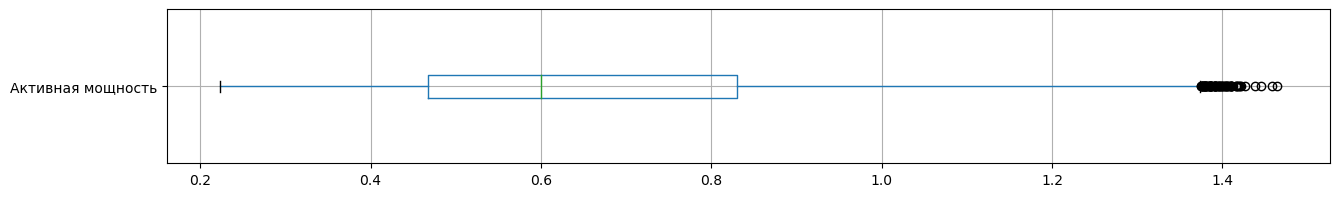

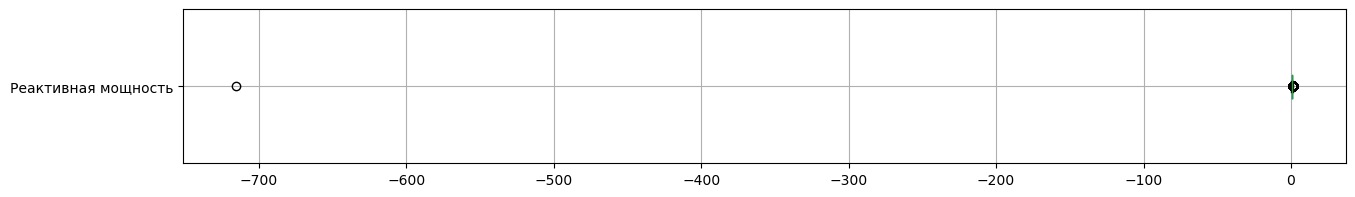

In [6]:
plt.figure(figsize=(15, 2))
df_arc_new.boxplot('Активная мощность', vert=False)
plt.show()

plt.figure(figsize=(15, 2))
df_arc_new.boxplot('Реактивная мощность', vert=False)
plt.show()

* Сразу видно, что есть выброс в столбце реактивной мощности. 
* Удалим строку и посмотрим график:

In [7]:
df_arc_new = df_arc_new[df_arc_new['Реактивная мощность']>=0]

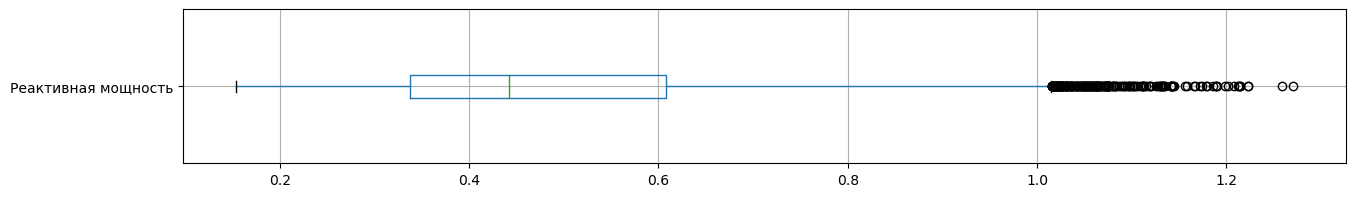

In [8]:
plt.figure(figsize=(15, 2))
df_arc_new.boxplot('Реактивная мощность', vert=False)
plt.show()

**Рассмотрим плотность распределения:**

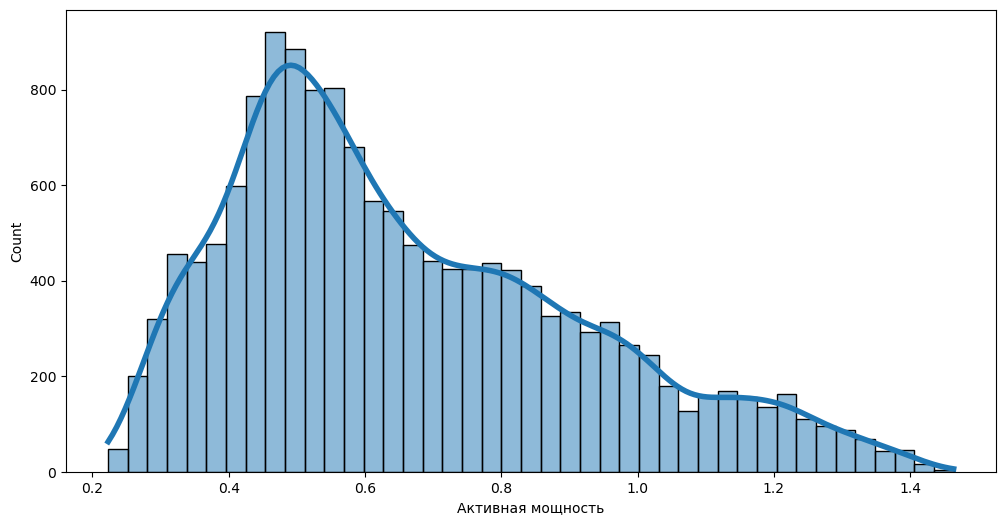

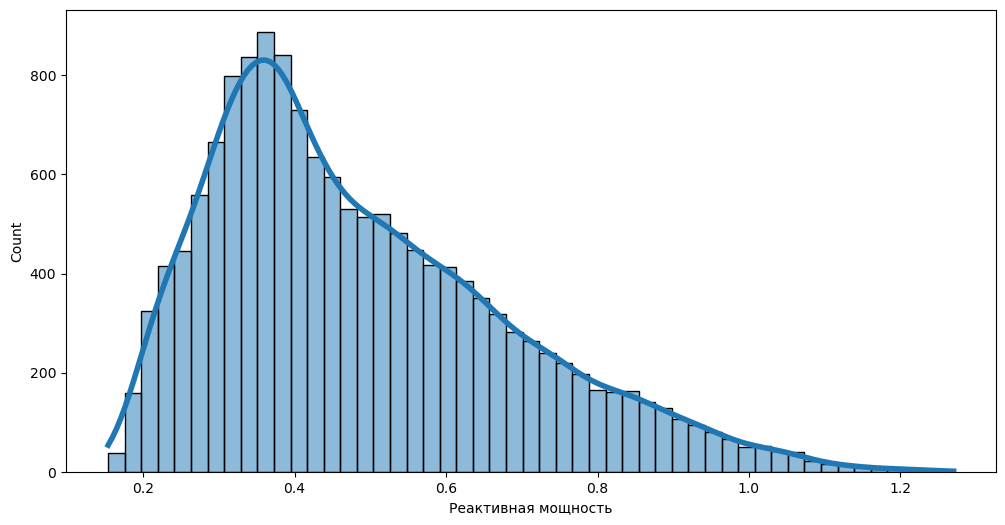

In [9]:
plt.figure(figsize=(12,6))
sns.histplot(df_arc_new['Активная мощность'], kde=True, line_kws={'linewidth':4})
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(df_arc_new['Реактивная мощность'], kde=True, line_kws={'linewidth':4})
plt.show()

* Как видно из графиков, есть значения, которые уходят от нормального распределения. 
* У заказчика необходимо выяснить, являются ли эти значения выбросами или такая подача мощностей была необходима для очистки стали.

#### Рассмотрим таблицы подачи материалов при плавке:

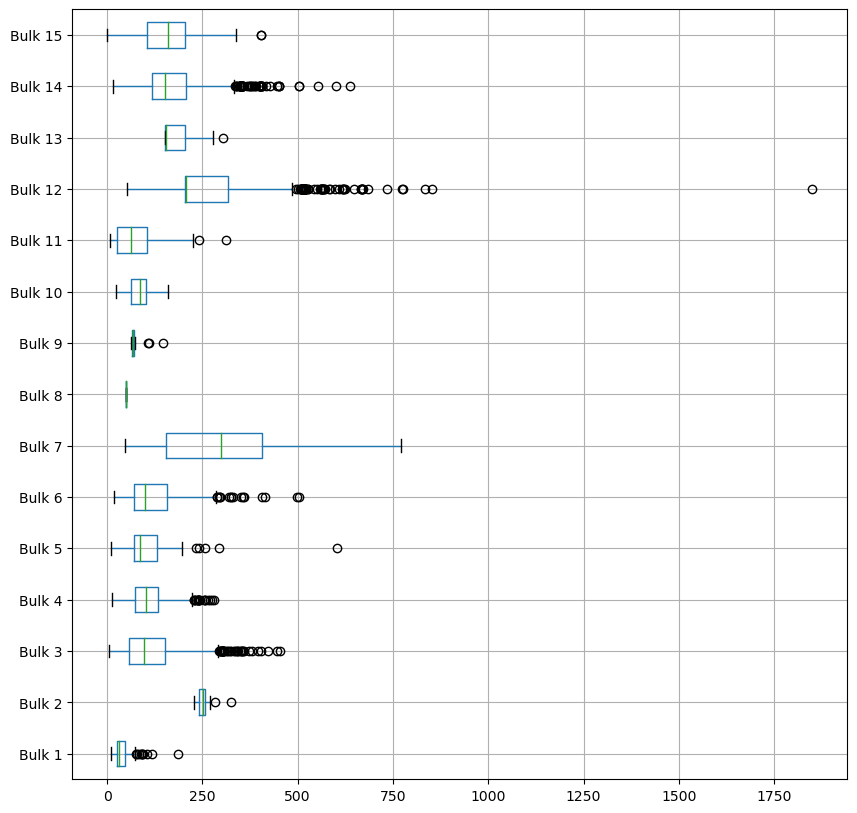

In [10]:
plt.figure(figsize=(10, 10))
df_bulk_new.boxplot([col for col in df_bulk_new.columns if col != 'key'], vert=False)
plt.show()

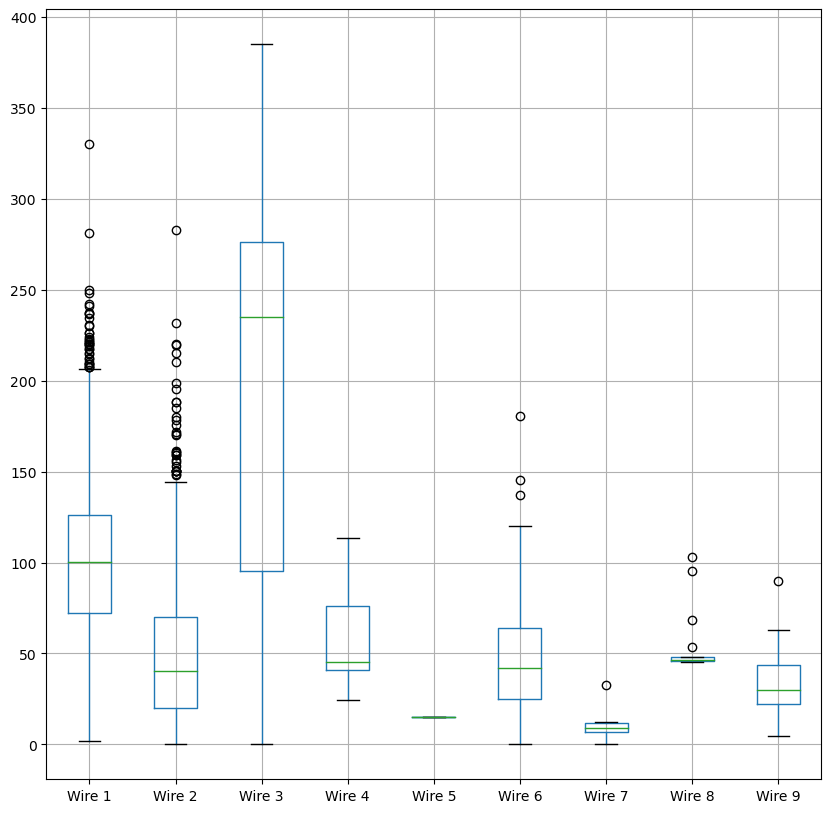

In [11]:
plt.figure(figsize=(10, 10))
df_wire_new.boxplot([col for col in df_wire_new.columns if col != 'key'])
plt.show()

**Из боксплотов следует:**

* В таблице `df_bulk_new:`
  * Почти все столбцы с небольшимы выбросами (данные за усами)
  * `Bulk 8` добавляли лишь единожды. Возможно такими данными можно пренебречь.
  * `Bulk 12` есть аномально большое значение. Думаю такую строку можно исключить, чтобы не исказить модель.
* В таблице `df_wire_new:`
  * Почти все столбцы с небольшимы выбросами (данные за усами).
  * В `Wire 1` и `Wire 2` есть аномальные значения. Думаю такие строки можно исключить, чтобы не исказить модель.
  * `Wire 5` добавляли лишь единожды. Возможно такими данными можно пренебречь.
* Общий итог:
  * Есть некоторые материалы, которые добавляли очень редко, нужно рассмотреть, как повлияет исключение таких столбцов на модель.
  * Нужно выбрать максимальное количество материала, которое добавляют и исключить данные по столбцам, которые будут считаться выбросами.
  * Пропуска можно заполнить значением 0
  * Нужно уточнить - можно ли использовать итоговый объём по столбцам и так же проверить, как повлияет это на итоговую модель.

#### Рассмотрим подачу газа:

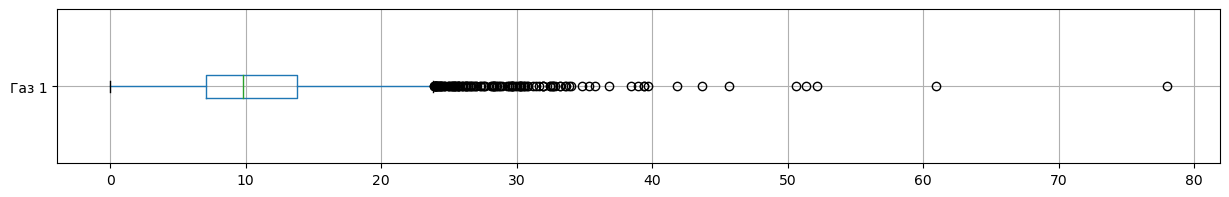

In [12]:
plt.figure(figsize=(15, 2))
df_gas_new.boxplot('Газ 1', vert=False)
plt.show()

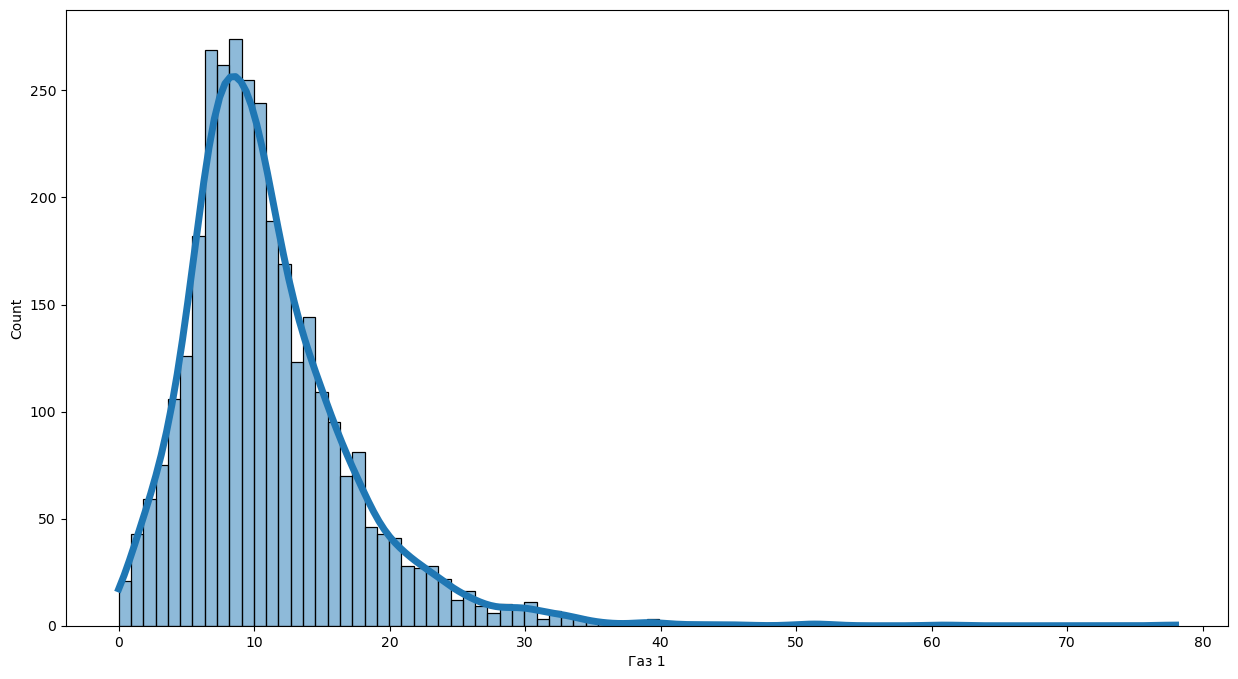

In [13]:
plt.figure(figsize=(15,8))
sns.histplot(df_gas_new['Газ 1'], kde=True, line_kws={'linewidth':5})
plt.show()

**Исходя из графиков:**
* В подаче газа есть выбросы, предположительно значения выше 40.
* Может это реальные данные. Нужно уточнить у заказчика.

#### Рассмотрим измерение температуры:

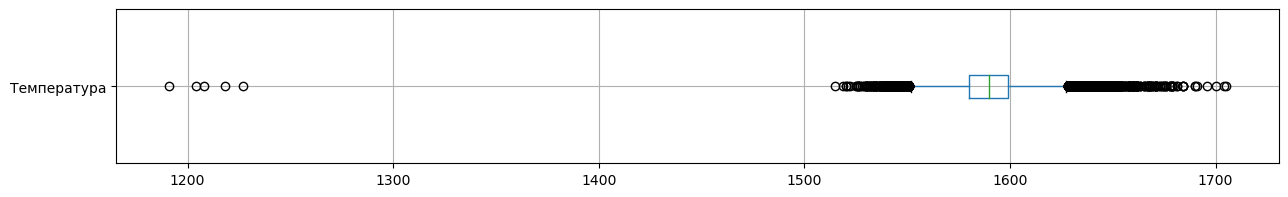

In [14]:
plt.figure(figsize=(15, 2))
df_temp_new.boxplot('Температура', vert=False)
plt.show()

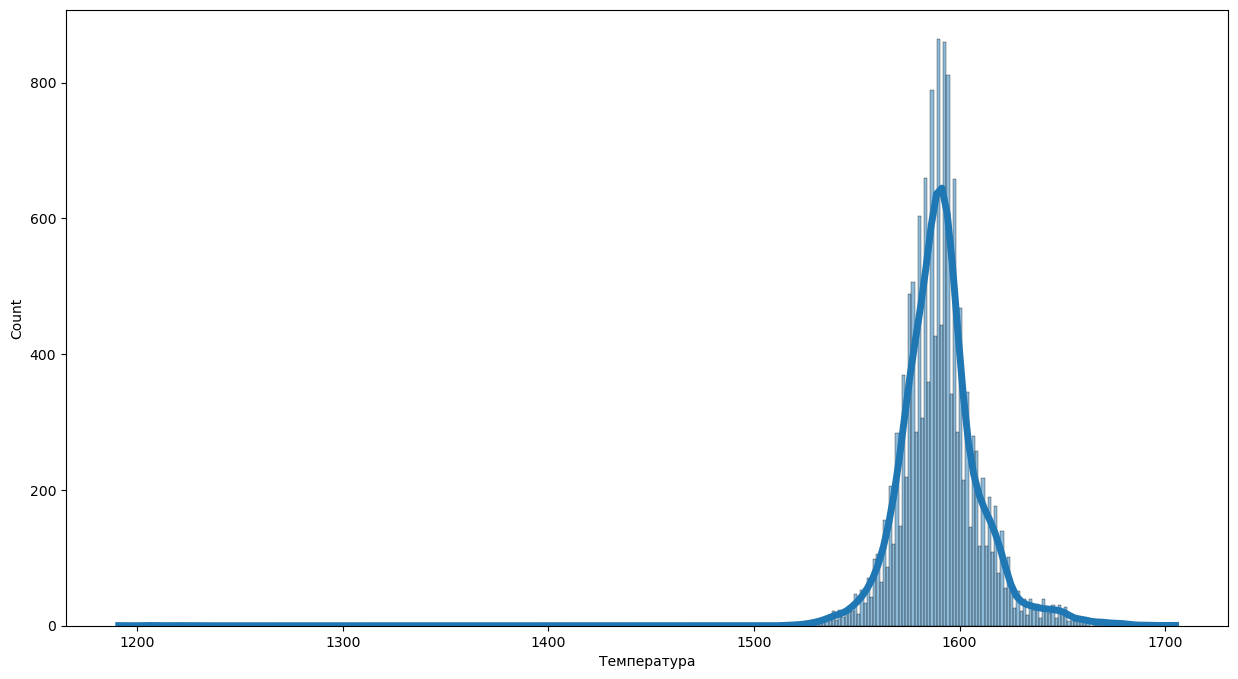

In [15]:
plt.figure(figsize=(15,8))
sns.histplot(df_temp_new['Температура'], kde=True, line_kws={'linewidth':5})
plt.show()

**Исходя из графиков:**
* Температура плавления стали от 1300 до 1500. 
* Eсть значения, которые значительно ниже, думаю их нужно будет убрать.
* Значения выше 1300 можно оставить.

### Общий вывод:

Исходя из исследования выше:
* В некоторых таблицах есть данные, которые можно посчитать за выбросы.
* В целевом значении есть пустые строки.
* Есть некоторые материалы для плавления, которые добавляли очень редко, нужно рассмотреть, как повлияет исключение таких столбцов на модель.
* Нужно выбрать максимальное количество материала, которое добавляют и исключить данные по столбцам, которые будут считаться выбросами.
* В таблицах добавления материалов пропуска можно заполнить значением 0
* Нужно уточнить - можно ли использовать итоговый объём по материалам и так же проверить, как повлияет это на итоговую модель.
* В подаче газа есть выбросы, предположительно значения выше 40. Может это реальные данные. Нужно уточнить у заказчика.
* В температуре есть значения сильно ниже плавления стали ими можно пренебречь, как аномальными, значения выше 1300 можно оставить.

## Список вопросов заказчику:

**Прежде, чем объединять таблицы и заполнять пропуски/удалять аномалии/добавлять параметры, необходимо уточнить следующие вопросы:**
* При добавлении материалов, какие значения можно считать выбросами? Стоит ли исключить те строки, в которых значения уходят за нормальное распределение и ящиков с усами?
* Для добавления дополнительных параметров: стоит рассчитать общую мощность или лучше уже рассчитать энергию (мощность на дельту времени)? Или даже оба параметра оставить?
* Можно ли исключить те материалы, которые добавляли слишком редко? Или лучше взять общее количество материала по отдельности: Bulk и Wire, а может вообще общую сумму по ковшу?
* Если в целевой метрике нет значений - стоит ли их заполнять медианной по ковшу? Просто их приблизительно 700, что сильно уменьшает количество данных. Но, думаю, может произойти утечка данных из-за того, что будем первое измерение оставлять.
* Может, стоит добавить еще дополнительные параметры - количество нагревов, например, или количество различных добавок по столбцам Wire и Bulk? Или стоит просто рассмотреть все способы и уже просто удалять те столбцы, которые будут сильно коррелировать с остальными или выдавать низкую метрику?
* Что еще стоит рассмотреть в таких данных? Что добавить и что удалить?
* Прошу так же рассмотреть исследование и дать замечания. А так же, по возможности, дополнить выводы.

Для начала переменуем датафрейммы для упрощения написания кода

In [16]:
df_arc = df_arc_new
df_bulk = df_bulk_new
df_bulk_time = df_bulk_time_new
df_gas = df_gas_new
df_temp = df_temp_new
df_wire = df_wire_new
df_wire_time = df_wire_time_new

# Предобработка данных

## Выбросы, пропуски, ненужные строки, замена типа данных

#### Таблица с инертным газом

Переименуем столбец Газ 1 в английский эквивалент.

In [17]:
df_gas = df_gas.rename(columns = {'Газ 1': 'gas_amount'})
df_gas.head()

,key,gas_amount
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


#### Переведем время из `object` в `datetime`

In [18]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'])

df_bulk_time['Bulk 1'] = pd.to_datetime(df_bulk_time['Bulk 1'])
df_bulk_time['Bulk 2'] = pd.to_datetime(df_bulk_time['Bulk 2'])
df_bulk_time['Bulk 3'] = pd.to_datetime(df_bulk_time['Bulk 3'])
df_bulk_time['Bulk 4'] = pd.to_datetime(df_bulk_time['Bulk 4'])
df_bulk_time['Bulk 5'] = pd.to_datetime(df_bulk_time['Bulk 5'])
df_bulk_time['Bulk 6'] = pd.to_datetime(df_bulk_time['Bulk 6'])
df_bulk_time['Bulk 7'] = pd.to_datetime(df_bulk_time['Bulk 7'])
df_bulk_time['Bulk 8'] = pd.to_datetime(df_bulk_time['Bulk 8'])
df_bulk_time['Bulk 9'] = pd.to_datetime(df_bulk_time['Bulk 9'])
df_bulk_time['Bulk 10'] = pd.to_datetime(df_bulk_time['Bulk 10'])
df_bulk_time['Bulk 11'] = pd.to_datetime(df_bulk_time['Bulk 11'])
df_bulk_time['Bulk 12'] = pd.to_datetime(df_bulk_time['Bulk 12'])
df_bulk_time['Bulk 13'] = pd.to_datetime(df_bulk_time['Bulk 13'])
df_bulk_time['Bulk 14'] = pd.to_datetime(df_bulk_time['Bulk 14'])
df_bulk_time['Bulk 15'] = pd.to_datetime(df_bulk_time['Bulk 15'])

df_wire_time['Wire 1'] = pd.to_datetime(df_wire_time['Wire 1'])
df_wire_time['Wire 2'] = pd.to_datetime(df_wire_time['Wire 2'])
df_wire_time['Wire 3'] = pd.to_datetime(df_wire_time['Wire 3'])
df_wire_time['Wire 4'] = pd.to_datetime(df_wire_time['Wire 4'])
df_wire_time['Wire 5'] = pd.to_datetime(df_wire_time['Wire 5'])
df_wire_time['Wire 6'] = pd.to_datetime(df_wire_time['Wire 6'])
df_wire_time['Wire 7'] = pd.to_datetime(df_wire_time['Wire 7'])
df_wire_time['Wire 8'] = pd.to_datetime(df_wire_time['Wire 8'])
df_wire_time['Wire 9'] = pd.to_datetime(df_wire_time['Wire 9'])


In [19]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


#### Температура

* Необходимо оставить только те пиртии, у которых есть первичная и конечная температуры. 
* Убирем все партии, в которых есть только одна запись.

In [20]:
temp = df_temp.groupby('key')['Температура'].count().reset_index()
temp['Температура'].value_counts()

Температура
1     741
5     688
6     580
4     395
7     388
8     152
3     136
9      66
2      32
10     21
11      7
12      3
13      2
14      2
16      2
17      1
Name: count, dtype: int64

* 741 партия имеет только 1 замер температуры.

In [21]:
temp_1 = temp.loc[temp['Температура'] == 1,'key']
temp_1

192      195
276      279
2477    2500
2478    2501
2479    2502
        ... 
3211    3237
3212    3238
3213    3239
3214    3240
3215    3241
Name: key, Length: 741, dtype: int64

* Удаляем строки, `key` которых находится в значениях temp_1.

In [22]:
df_temp_upd = df_temp.copy()
df_temp_upd = df_temp_upd.drop(df_temp_upd[df_temp_upd['key'].isin(temp_1.values)].index)

df_temp_upd

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


* Создаим список партий и пробежимся по нему выбирая первую и последнюю температуру.

In [23]:
keys = df_temp_upd['key'].unique()

In [24]:
temp_start_end = pd.DataFrame(columns=['key','temp_start', 'temp_end'])

i = 0
for key in keys:
    
    row = df_temp_upd.query('key == @key').reset_index()
    start = row['Температура'].tolist()[0]
    end = row['Температура'].tolist()[-1]
    
    temp_start_end.loc[i, 'key'] = key
    temp_start_end.loc[i, 'temp_start'] = start
    temp_start_end.loc[i, 'temp_end'] = end
    
    i += 1


In [25]:
temp_start_end

,key,temp_start,temp_end
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


In [26]:
temp_start_end.isna().sum()

key           0
temp_start    0
temp_end      0
dtype: int64

* Готово. 
* Все пропуски так же удалены. 
* Проверим случайную партию из нового датасета и исходного.

In [27]:
temp_start_end[temp_start_end['key'] == 184]

,key,temp_start,temp_end
181,184,1548.0,1599.0


In [28]:
df_temp_upd[df_temp_upd['key'] == 184]

,key,Время замера,Температура
1050,184,2019-05-10 15:22:40,1548.0
1051,184,2019-05-10 15:28:16,1558.0
1052,184,2019-05-10 15:36:17,1576.0
1053,184,2019-05-10 15:41:52,1569.0
1054,184,2019-05-10 15:49:23,1599.0


Хорошо. Мы нашли первую фичу и целевой признак temp_end.

#### Сумарное время работы электродов

* Считаем время работы электрода на каждой итерации.
* Вычитаем из времени окончания нагрева время начала. 
* Результат записываем в столбец `"heating_time"(Время нагрева)`.
* Затем группируем таблицу по key и складываем полученные значения нового столбца.

In [29]:
df_ht = df_arc[['key', 'Начало нагрева дугой', 'Конец нагрева дугой']]

df_ht['heating_time_sec'] = df_ht['Конец нагрева дугой'] - df_ht['Начало нагрева дугой']

df_ht_sum = df_ht.groupby('key')['heating_time_sec'].sum().reset_index()
df_ht_sum['heating_time_sec'] = df_ht_sum['heating_time_sec'].apply(pd.Timedelta.total_seconds).astype('int')

df_ht_sum

,key,heating_time_sec
0,1,1098
1,2,811
2,3,655
3,4,741
4,5,869
...,...,...
3209,3237,909
3210,3238,546
3211,3239,1216
3212,3240,839


#### Расчет полной мощности

Расчмтывать будем по формуле
$$ S = \sqrt{P^2+Q^2} $$
где S - полная мощность, P - активная мощность, Q - реактивная мощность.

In [30]:
df_arc['full_power'] = np.sqrt(df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2) 
df_arc= df_arc.rename(columns = {'Активная мощность':'active_power', 'Реактивная мощность':'reactive_power'})

df_arc

,key,Начало нагрева дугой,Конец нагрева дугой,active_power,reactive_power,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0.532085
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0.792429
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,1.293389
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0.641792


* Оставим нужные столбцы и сразу сгруппируем по `key`.

In [31]:
df_arc_upd = df_arc

In [32]:
df_arc_upd = df_arc_upd[['key','active_power','reactive_power','full_power']]
df_arc_upd = df_arc_upd.groupby('key')[['active_power','reactive_power','full_power']].sum()

df_arc_upd

,active_power,reactive_power,full_power
key,,,
1,3.036730,2.142821,3.718736
2,2.139408,1.453357,2.588349
3,4.063641,2.937457,5.019223
4,2.706489,2.056992,3.400038
5,2.252950,1.687991,2.816980
...,...,...,...
3237,2.541872,2.025417,3.250657
3238,1.374821,1.038103,1.723937
3239,4.848005,3.541541,6.014480


#### Количество проволоки

* Заменим пропуски 0
* Найдем общий вес затраченной проволоки для каждой партии.

In [33]:
df_wire = df_wire.fillna(0)

In [34]:
df_wire['wire_full'] = (df_wire['Wire 1'] + df_wire['Wire 2'] + df_wire['Wire 3'] + df_wire['Wire 4'] +
                        df_wire['Wire 5'] + df_wire['Wire 6'] + df_wire['Wire 7'] + df_wire['Wire 8'] + 
                        df_wire['Wire 9'])

In [35]:
df_wire.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_full
2212,2323,114.135842,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.135842
1540,1619,155.141998,45.179680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.321678
338,365,196.793999,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.793999
2496,2623,56.085121,52.146641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.231762
1611,1691,105.066002,50.095760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.161762


In [36]:
df_wire_upd = df_wire[['key','wire_full']]

df_wire_upd.sample(5)

,key,wire_full
2934,3093,127.176397
125,141,135.638881
2420,2547,117.634392
577,613,151.070404
2893,3052,60.278397


#### Подача сухих веществ

* Заменим пропуски 0
* Найдем по аналогии с проволокой общий вес сухих веществ для каждой партии.

In [37]:
df_bulk = df_bulk.fillna(0)

In [38]:
df_bulk['bulk_full'] = (df_bulk['Bulk 1'] + df_bulk['Bulk 2'] + df_bulk['Bulk 3'] + df_bulk['Bulk 4'] +
                        df_bulk['Bulk 5'] + df_bulk['Bulk 6'] + df_bulk['Bulk 7'] + df_bulk['Bulk 8'] +
                        df_bulk['Bulk 9'] + df_bulk['Bulk 10'] + df_bulk['Bulk 11'] + df_bulk['Bulk 12'] + 
                        df_bulk['Bulk 13'] + df_bulk['Bulk 14'] + df_bulk['Bulk 15'])

In [39]:
df_bulk.sample(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_full
2727,2830,0.0,0.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,208.0,0.0,102.0,104.0,526.0
3078,3188,28.0,0.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,514.0,0.0,250.0,0.0,884.0
2291,2374,0.0,0.0,0.0,0.0,0.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,223.0,0.0,300.0
35,36,0.0,0.0,0.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,153.0,155.0,627.0
408,434,0.0,0.0,0.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,313.0,154.0,1048.0
868,904,0.0,0.0,201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,411.0,0.0,256.0,205.0,1073.0
1064,1111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,99.0,203.0,558.0
2058,2130,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,364.0,0.0,109.0,226.0,880.0
2920,3028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,150.0,156.0,562.0
1038,1084,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,206.0,0.0,100.0,105.0,505.0


In [40]:
df_bulk_upd = df_bulk[['key','bulk_full']]

df_bulk_upd.sample(5)

,key,bulk_full
1175,1224,912.0
689,722,739.0
900,939,623.0
948,993,896.0
1242,1292,765.0


### Объединение таблиц

* Назовем итоговую таблицу `df_full`.

In [41]:
df_full = temp_start_end.copy()

df_full

,key,temp_start,temp_end
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


Присоединяем данные о работе электродов.

In [42]:
df_full = df_full.merge(df_arc_upd, on='key')
df_full.sample(5)

,key,temp_start,temp_end,active_power,reactive_power,full_power
2092,2111,1607.0,1590.0,3.444591,2.699485,4.381331
2018,2036,1597.0,1596.0,1.855377,1.361075,2.301155
1907,1924,1568.0,1596.0,4.602882,3.572729,5.828430
1668,1685,1574.0,1589.0,4.563226,3.337872,5.659666
2469,2494,1585.0,1591.0,1.504776,1.102095,1.865880


Количество инертного газа.

In [43]:
df_full = df_full.merge(df_gas, on='key')
df_full.sample(5)

,key,temp_start,temp_end,active_power,reactive_power,full_power,gas_amount
2064,2084,1560.0,1596.0,2.132401,1.568311,2.649124,10.898872
1947,1966,1527.0,1578.0,3.377053,2.391140,4.141400,18.710089
369,377,1634.0,1648.0,1.391220,1.003030,1.715801,5.937243
1626,1645,1585.0,1591.0,4.587558,3.493540,5.769012,15.014276
2206,2227,1592.0,1595.0,2.194527,1.492324,2.653897,12.308052


Общее время нагрева.

In [44]:
df_full = df_full.merge(df_ht_sum, on='key')
df_full.sample(5)

,key,temp_start,temp_end,active_power,reactive_power,full_power,gas_amount,heating_time_sec
1730,1749,1606.0,1612.0,4.582827,3.227286,5.611452,9.712806,874
840,856,1568.0,1575.0,4.983029,3.435216,6.061871,12.670113,896
445,454,1592.0,1591.0,3.879890,2.788381,4.779789,12.784949,869
1796,1815,1608.0,1583.0,2.495622,2.012187,3.206688,6.996337,839
425,434,1615.0,1594.0,5.186012,3.868012,6.473083,26.548905,916


Количество проволоки.

In [45]:
df_full = df_full.merge(df_wire_upd, on='key')
df_full.sample(5)

,key,temp_start,temp_end,active_power,reactive_power,full_power,gas_amount,heating_time_sec,wire_full
537,575,1562.0,1591.0,1.705407,1.188154,2.079358,6.696740,668,145.426316
715,765,1652.0,1596.0,1.182207,0.916670,1.497809,5.458366,224,80.776797
1139,1210,1581.0,1588.0,2.204575,1.632876,2.744885,5.941391,450,67.953598
401,436,1593.0,1575.0,1.232722,0.765612,1.451178,7.100680,267,36.220081
1507,1589,1598.0,1621.0,3.084405,2.193066,3.788054,9.096814,735,170.024414


Количество сыпучих добавок.

In [46]:
df_full = df_full.merge(df_bulk_upd, on='key')
df_full.sample(5)

,key,temp_start,temp_end,active_power,reactive_power,full_power,gas_amount,heating_time_sec,wire_full,bulk_full
1839,1964,1540.0,1575.0,4.461346,2.976758,5.365609,12.226091,1233,50.057281,533.0
323,362,1581.0,1592.0,3.224507,2.464910,4.059876,5.441219,564,115.268402,651.0
502,549,1594.0,1587.0,1.449184,1.180530,1.869819,15.931603,830,88.384393,1046.0
1656,1774,1620.0,1597.0,1.412080,1.019235,1.744876,2.525262,245,67.064400,29.0
1182,1274,1583.0,1591.0,4.314708,3.394599,5.497225,7.957930,833,78.155998,585.0


Проверяем информацию о таблице.

In [47]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               2329 non-null   object 
 1   temp_start        2329 non-null   object 
 2   temp_end          2329 non-null   object 
 3   active_power      2329 non-null   float64
 4   reactive_power    2329 non-null   float64
 5   full_power        2329 non-null   float64
 6   gas_amount        2329 non-null   float64
 7   heating_time_sec  2329 non-null   int32  
 8   wire_full         2329 non-null   float64
 9   bulk_full         2329 non-null   float64
dtypes: float64(6), int32(1), object(3)
memory usage: 173.0+ KB


Переводим оставшиеся столбцы в int64.

In [48]:
df_full['temp_start'] = df_full['temp_start'].astype('int64')
df_full['temp_end'] = df_full['temp_end'].astype('int64')

И еще раз смотрим на данные.

In [49]:
df_full.describe().T

,count,mean,std,min,25%,50%,75%,max
temp_start,2329.0,1586.718763,28.290792,1191.000000,1571.000000,1587.000000,1603.000000,1660.000000
temp_end,2329.0,1593.365393,11.200915,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
active_power,2329.0,3.125033,1.221007,0.267676,2.293900,3.035365,3.834300,12.375636
reactive_power,2329.0,2.300522,0.903968,0.196228,1.669572,2.225398,2.829159,8.949049
full_power,2329.0,3.884654,1.518157,0.331897,2.843058,3.767499,4.769421,15.288271
gas_amount,2329.0,11.375600,6.392041,0.008399,7.282948,10.100950,14.216688,77.995040
heating_time_sec,2329.0,807.600687,340.897332,57.000000,581.000000,778.000000,993.000000,4189.000000
wire_full,2329.0,125.208530,63.683386,1.918800,89.013596,116.101440,151.568558,568.777664
bulk_full,2329.0,609.630313,287.599678,19.000000,440.000000,609.000000,795.000000,3235.000000


Посмотрим на зависимости.

In [50]:
corr = df_full.corr()
corr

,key,temp_start,temp_end,active_power,reactive_power,full_power,gas_amount,heating_time_sec,wire_full,bulk_full
key,1.000000,-0.019186,-0.097242,-0.023422,-0.021349,-0.022668,-0.043486,-0.029519,0.002886,-0.026203
temp_start,-0.019186,1.000000,0.252443,-0.119724,-0.120394,-0.120201,0.037341,-0.304995,0.104003,-0.077137
temp_end,-0.097242,0.252443,1.000000,0.177339,0.171878,0.175668,0.059160,0.278716,0.061061,0.222658
active_power,-0.023422,-0.119724,0.177339,1.000000,0.992424,0.999030,0.370985,0.721249,0.167982,0.388297
reactive_power,-0.021349,-0.120394,0.171878,0.992424,1.000000,0.996868,0.367954,0.713422,0.167753,0.384299
full_power,-0.022668,-0.120201,0.175668,0.999030,0.996868,1.000000,0.370555,0.719734,0.168215,0.387519
gas_amount,-0.043486,0.037341,0.059160,0.370985,0.367954,0.370555,1.000000,0.396306,0.215411,0.314006
heating_time_sec,-0.029519,-0.304995,0.278716,0.721249,0.713422,0.719734,0.396306,1.000000,0.091965,0.551844
wire_full,0.002886,0.104003,0.061061,0.167982,0.167753,0.168215,0.215411,0.091965,1.000000,0.007119
bulk_full,-0.026203,-0.077137,0.222658,0.388297,0.384299,0.387519,0.314006,0.551844,0.007119,1.000000


In [51]:
corr.style.background_gradient(cmap='coolwarm')

,key,temp_start,temp_end,active_power,reactive_power,full_power,gas_amount,heating_time_sec,wire_full,bulk_full
key,1.000000,-0.019186,-0.097242,-0.023422,-0.021349,-0.022668,-0.043486,-0.029519,0.002886,-0.026203
temp_start,-0.019186,1.000000,0.252443,-0.119724,-0.120394,-0.120201,0.037341,-0.304995,0.104003,-0.077137
temp_end,-0.097242,0.252443,1.000000,0.177339,0.171878,0.175668,0.059160,0.278716,0.061061,0.222658
active_power,-0.023422,-0.119724,0.177339,1.000000,0.992424,0.999030,0.370985,0.721249,0.167982,0.388297
reactive_power,-0.021349,-0.120394,0.171878,0.992424,1.000000,0.996868,0.367954,0.713422,0.167753,0.384299
full_power,-0.022668,-0.120201,0.175668,0.999030,0.996868,1.000000,0.370555,0.719734,0.168215,0.387519
gas_amount,-0.043486,0.037341,0.059160,0.370985,0.367954,0.370555,1.000000,0.396306,0.215411,0.314006
heating_time_sec,-0.029519,-0.304995,0.278716,0.721249,0.713422,0.719734,0.396306,1.000000,0.091965,0.551844
wire_full,0.002886,0.104003,0.061061,0.167982,0.167753,0.168215,0.215411,0.091965,1.000000,0.007119
bulk_full,-0.026203,-0.077137,0.222658,0.388297,0.384299,0.387519,0.314006,0.551844,0.007119,1.000000


* На финальную температуру заметно влияет затраченная мощность, длительность нагрева и начальная температура. Что, в целом, логично.
* Корреляция не обнаружена между финальной температурой и двумя признаками: объемом инертного газа и количеством потраченной проволоки.
* Данные готовы для машинного обучения. Составляем выводы и обучаем модели.

### Вывод

* Провели этап подготовки данных.
* Очистили температуру от ненужных записей, перевели количество сыпучих добавок и затраченной проволоки в суммарный объем. Перевели данные в удобный вид.
* Добавили две новые фичи: полная мощность, время нагрева.
* Соединили таблицы в один датасет `df_full`.
* Замечены корреляции между целевым признаком и параметрами работы электродов. 
* Количество добавок и газа практически не влияет на изменение финальной температуры.

**Переходим к машинному обучению.**

## Машинное обучение

* Финальные данные содержат **2329 записей**. 
* Мы будем использовать две выборки: `обучающую` и `тестовую`.
* Валидация будет проводиться `кросс-валидацией` на обучающих данных.

Для моделирования, рассмотрим несколько деревянных моделей и бустинговые модели, основанные на дереве решений:
* Дерево решений
* Случайный лес
* LightGBM
* CatBoost

<b>Комментарий студента: поправил</b></font>

* Разделим датасет на тренировочную и тестовую 

In [52]:
features = df_full.drop(['key','temp_end'], axis=1)
target = df_full['temp_end']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25, random_state=RANDOM_STATE)

<b>Комментарий студента: поправил</b></font>

In [53]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1746, 8) (583, 8) (1746,) (583,)


Хорошо, данные готовы

#### Проверка модели на адекватность

Обучим дамми модельку предсказывать медианные значения температуры и посмотрим на ее метрики.

In [54]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train, y_train)
predicted_dummy = dummy_regr.predict(X_test)

mae_on_dummy = mean_absolute_error(y_test, predicted_dummy)
print('MAE Dummy:',mae_on_dummy)

MAE Dummy: 8.025728987993139


* Если дамми дала такой результат, значит, мы движемся в верном направлении.

**Посмотрим на нормальные модели.**

Создадим заготовку для результатов.

In [55]:
analisys = pd.DataFrame({'model':[], 'MAE_model':[], 'MAE_on_train':[]})
all_models = []

Cоздадим функцию для подбора параметров

In [56]:
def train_model(model, parameters):
    
    model_random = GridSearchCV(estimator=model,
                                param_grid=parameters, # используем параметры
                                scoring='neg_mean_absolute_error', # используем необходимую метрику
                                cv=5, 
                                verbose=1)

    # посмотрим время обучения 
    start = time()
    model_random.fit(X_train, y_train)
    print('GridSearchCV подбирал параметры %.2f секунд' %(time() - start))
    
    # высчитаем метрики
    mae = model_random.best_score_ * -1
    mae_on_train = mean_absolute_error(y_train, model_random.predict(X_train))
    
    print('Лучшие параметры:', model_random.best_params_)
    print('MAE обученной модели:', mae)
    print('MAE на тренировочной выборке:', mae_on_train)
    
    # заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, mae, mae_on_train])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

#### Дерево решений

In [57]:
ran_grid_tree = {"max_depth": list(range(3, 12))}

dtr = DecisionTreeRegressor(random_state = RANDOM_STATE)

dtr_random = train_model(dtr, ran_grid_tree)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
GridSearchCV подбирал параметры 0.96 секунд
Лучшие параметры: {'max_depth': 3}
MAE обученной модели: 7.594314472535052
MAE на тренировочной выборке: 7.285474565398215


<b>Комментарий студента: поправил</b></font>

#### Случайный лес

In [58]:
ran_grid_forest = {
    'max_depth': list(range(2, 9)),
    'n_estimators': [50, 100, 200, 300]
}

rfr = RandomForestRegressor(random_state = RANDOM_STATE, n_jobs=-1)

rfr_random = train_model(rfr, ran_grid_forest)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
GridSearchCV подбирал параметры 68.74 секунд
Лучшие параметры: {'max_depth': 8, 'n_estimators': 200}
MAE обученной модели: 6.863618032919336
MAE на тренировочной выборке: 4.938243526540954


#### LightGBM

In [59]:
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression'
                         )

gbm_random = train_model(gbm, rand_lgbm_param)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
GridSearchCV подбирал параметры 3.82 секунд
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5}
MAE обученной модели: 6.949617377643638
MAE на тренировочной выборке: 4.979554053662066


#### CatBoost

In [60]:
rand_cat_param = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1]
}

cat = CatBoostRegressor(random_state = RANDOM_STATE, verbose=False) 

cat_random = train_model(cat, rand_cat_param)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV подбирал параметры 96.47 секунд
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 6}
MAE обученной модели: 6.859570645212678
MAE на тренировочной выборке: 5.678535890967894


#### Рассмотрим метрики на графиках:

In [61]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

,model,MAE_model,MAE_on_train,names
0,DecisionTreeRegressor(random_state=150523),7.594314,7.285475,DecisionTree
1,"RandomForestRegressor(n_jobs=-1, random_state=...",6.863618,4.938244,RandomForest
2,LGBMRegressor(objective='regression'),6.949617,4.979554,LightGBM
3,<catboost.core.CatBoostRegressor object at 0x0...,6.859571,5.678536,CatBoost


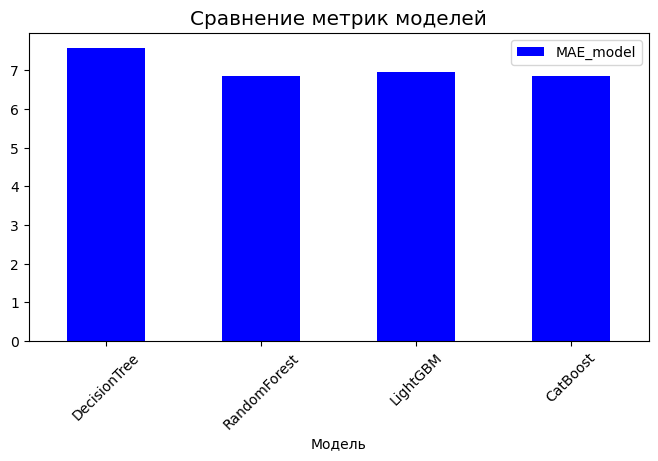

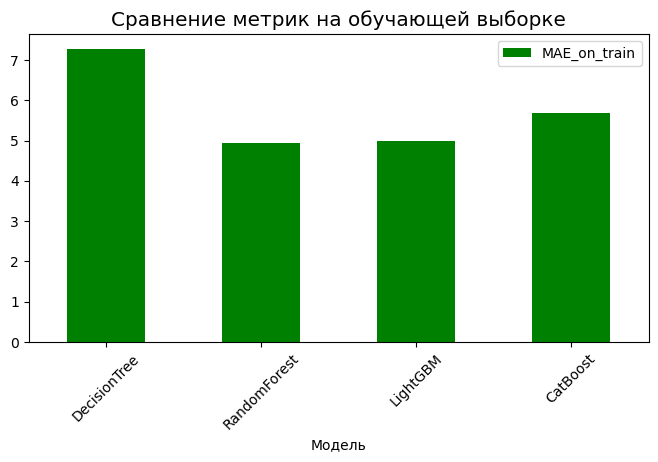

In [62]:
analisys.plot.bar(y='MAE_model', x='names', rot = 45, figsize=(8,4), color='blue')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='MAE_on_train', x='names', rot = 45, figsize=(8,4), color='green')
plt.title('Сравнение метрик на обучающей выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

**Вывод:**
* Из полученных моделей наилучше всего показала себя модель `CatBoost`с параметрами `learning_rate: 0.01`, `max_depth: 6`.

**Данную модель можно использовать в тестировании.**

<b>Комментарий студента: поправил</b></font>

## Тестирование модели:

Воспользуемся обученной моделью и посмотрим метрики на тестовой выборке:

In [63]:
%%time
predicted = cat_random.predict(X_test)
mae_on_test = mean_absolute_error(y_test, predicted)
print('MAE на тестовой выборке при использовании GridSearchCV:', mae_on_test)

MAE на тестовой выборке при использовании GridSearchCV: 6.621725985297926
CPU times: total: 46.9 ms
Wall time: 7.06 ms


* Итоговая метрика ниже 6.8. 
* Модель можно использовать.

**Рассмотрим важность параметров:**

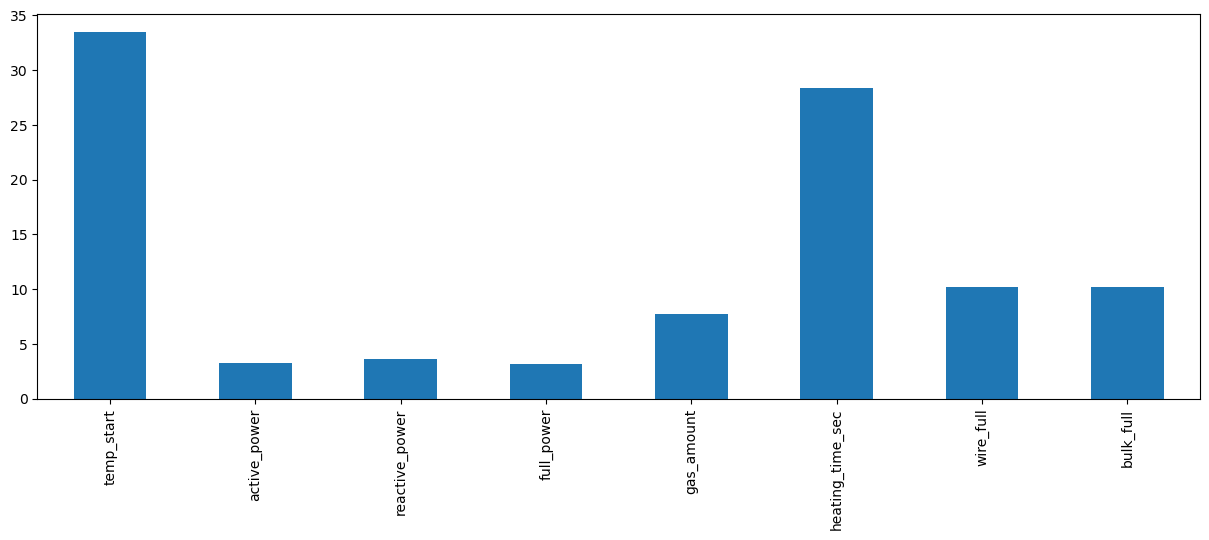

In [64]:
features = pd.Series(cat_random.best_estimator_.feature_importances_, index= X_train.columns)

plt.figure(figsize=(15,5))
features.plot.bar()
plt.show()


**Как видно из графика, для итоговой метрики наиболее важны параметры:**

* Время нагрева и первое измерение температуры

## Вывод

* На данном этапе было протестировано 5 моделей: дамми болванка, дерево решений, случайный лес, LightGBM и CatBoost.
* Для тестирования была выбрана модель `CatBoost` с параметрами `learning_rate: 0.01`, `max_depth: 6`
* Удалось достигнуть эталона порога МАЕ задания 




<b>Комментарий студента: поправил</b></font>

# Финальный отчет

**Целью проекта является создание модели для подсчета темпиратуры**

В процессе выполнения задачи была проделана следующая работа:
* Были изучены о обработаны данные
* Подобрали и создали новые признаки для обучения модели
* Объеденили данные в один датасет
* Подобрали оптимальную модель

Основная трудность в работе это выбросы и малое количество наблюдений. Так же недостаточность параметров: при таком малом количестве наблюдений стоит так же запрашивать у заказчика дополнительные данные, чтобы еще лучше предсказывать метрику.

Итоговая модель:
* `CatBoost` с параметрами `learning_rate: 0.01`, `max_depth: 6` с покзателем метрики **`MAE=6.621`**

**Цель проекта выполнена, удалось достичь результата МАЕ < 6.8**

### Анализ выполнения плана

Первоначальный план был следующим:

**1. Предобработка данных**

Перевод даты в datetime формат, обработка выбросов (Реактивная мощность, сыпучие вещества, инетный газ), заполнение пропусков при необходимости). Решить вопрос о недостающих данных после общения с Тимлидом (найти, удалить, заполнить)

**2. Подбор необходимых фич**

Нужны ли нам все столбцы Bulk и Wire, В большую часть сплавов добавляют лишь некоторые. Необходимо определиться с группировкой по времени - нужна ли она.

**3. Объединение данных в одну таблицу**

Выделение целевого и учебных признаков. Скалирование данных при необходимости.

**4. Подбор и обучение моделей**

Тестирование дамми болванки, деление сета на 2 выборки, подбор гиперпараметров и валидация моделей.

**5. Выбор и тестирование финальной модели**

Проверка модели на тестовой выборке. Описание результатов.

В целом структура плана была сохранена. За время обучения мы научились правильно выстраивать план работы. В финальном проекте я применил все полученные навыки.

Выбросы,  я не удалял и не менял. Отклоняющиеся значения были обусловлены технологическим процессом, а не ошибками измерений. Я пытался построить модель, максимально приближенную к реальным условиям.
Таблицы bulk и wire не имели корреляции с финальной температурой, но остались в финальной версии обучающих данных.

### Трудности проекта

* Постановка задачи и первичная обработка данных
  * Я провел анализ и собрал все вопросы в отдельный блок. Консультация ТимЛида дала на все ответы. Благодарю за понятные и полные комментарии.
* Основная трудность в работе это выбросы и малое количество наблюдений. Так же недостаточность параметров: при таком малом количестве наблюдений стоит так же запрашивать у заказчика дополнительные данные, чтобы еще лучше предсказывать метрику.  

### Ключевые шаги решения

Ключевые шаги решения

**1. Разумная постановка задачи**

Сначала продумать и прописать - что и как считать, затем уже писать код. В противном случае, мысли могут уйти в сторону.

**2. Качественная предобработка данных**

Оставлять или удалять выбросы. Какие фичи добавить и сгенерировать. Скалировать ли данные. Как обрабатывать пропуски. Все эти пункты влияют на качество работы модели.
В этом проекте я оставил данные практически в исходном виде. Повторю, что не видел смысла обрабатывать выбросы, потому что они являлись следствием технологического процесса.

**3. Машинное обучение и подбор гиперпараметров**
* На данном этапе было протестировано 5 моделей: дамми болванка, дерево решений, случайный лес, LightGBM и CatBoost.
* Для подбора гипервараметров исрользовался `GridSearchCV`


**4. Конкретные шаги проекта**

Чем лучше данные, тем качественнее работает модель. Ключевым шагом этой работы стало создание df_full. Сборного датасета с финальными фичами, на котором обучались модели. Удалось достичь метрики МАЕ < 6.8 пунктов на тестовой выборке. 

### Итоговая модель

**`CatBoost`**.

`МАЕ` на тестовой выборке = **6.621**. Время предсказания = **2.73 ms**.


Рекомендую модель в продакшн. Она отвечает требованиям по качеству и скорости работи. Можно следить за температурой в режиме практически реального времени.

### Общий вывод

* Целью проекта было создание модели для подсчета температуры. Цель успешно выполнена.
* Решены задачи - глубокая предобработка данных, создание новых признаков, машинное обучение.
* Финальная и рекомендованная модель - CatBoost, mae тестовой выборки 6.621, время предсказания 2.73 ms.

**Заключительный штрих - применение feature_importance_**

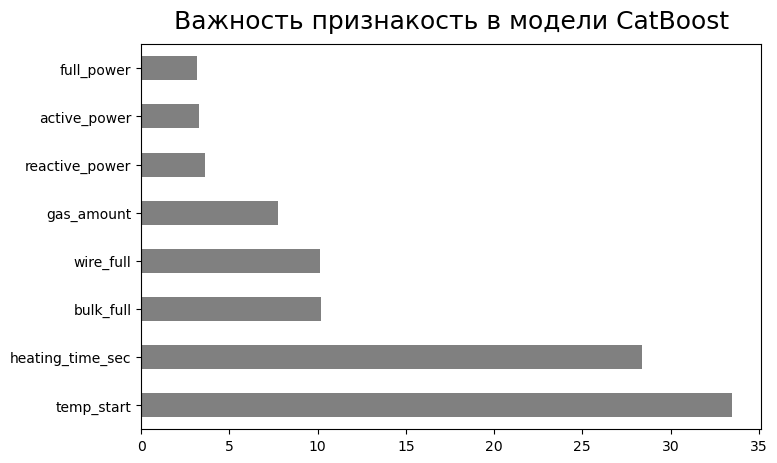

In [65]:
feat_importances = pd.Series(cat_random.best_estimator_.feature_importances_, index=X_train.columns)

plt.figure(figsize=(8,5))
feat_importances.nlargest(20).plot(kind='barh', color='gray')

plt.title('Важность признакость в модели CatBoost', size=18, y=1.02);

* Больше остальных на предсказание финальной температуры влияют начальная температура и  время между первым и последним замером температуры(**heating_time**).
* Именно в это время происходят добавки присадок и максимальные энергозатраты.